# Coursework 2: Generative Models

## Instructions

### Submission
Please submit one zip file on cate - *CW2.zip* containing the following:
1. A version of this notebook containing your answers. Write your answers in the cells below each question. **Please deliver the notebook including the outputs of the cells**
2. Your trained VAE model as *VAE_model.pth*
3. Your trained Generator and Discriminator: *DCGAN_model_D.pth and DCGAN_model_G.pth*


### Training
Training the GAN will take quite a long time (multiple hours), please refer to the 4 GPU options detailed in the logistics lecture. Some additional useful pointers:
* PaperSpace [guide if you need more compute](https://hackmd.io/@afspies/S1stL8Qnt)
* Lab GPUs via SSH.  The VSCode Remote Develop extension is recommended for this. For general Imperial remote working instructions see [this post](https://www.doc.ic.ac.uk/~nuric/teaching/remote-working-for-imperial-computing-students.html). You'll also want to [setup your environment as outlined here](https://hackmd.io/@afspies/Bkd7Zq60K).
* Use Colab and add checkpointing to the model training code; this is to handle the case where colab stops a free-GPU kernel after a certain number of hours (~4).
* Use Colab Pro - If you do not wish to use PaperSpace then you can pay for Colab Pro. We cannot pay for this on your behalf (this is Google's fault).


### Testing
TAs will run a testing cell (at the end of this notebook), so you are required to copy your data ```transform``` and ```denorm``` functions to a cell near the bottom of the document (it is demarkated). You are advised to check that your implementations pass these tests (in particular, the jit saving and loading may not work for certain niche functions)

### General
You can feel free to add architectural alterations / custom functions outside of pre-defined code blocks, but if you manipulate the model's inputs in some way, please include the same code in the TA test cell, so our tests will run easily.

<font color="orange">**The deadline for submission is Monday, 26 Feb by 6 pm** </font>

## Setting up working environment
You will need to install pytorch and import some utilities by running the following cell:

In [202]:
# !pip install torch torchvision altair seaborn
!git clone -q https://github.com/afspies/icl_dl_cw2_utils
from icl_dl_cw2_utils.utils.plotting import plot_tsne
from pathlib import Path
import tqdm

Here we have some default pathing options which vary depending on the environment you are using. You can of course change these as you please.

In [2]:
# Initialization Cell
WORKING_ENV = 'LABS' # Can be LABS, COLAB, PAPERSPACE, SAGEMAKER
USERNAME = 'ik323' # If working on Lab Machines - Your college username
assert WORKING_ENV in ['Own', 'LABS', 'COLAB', 'PAPERSPACE', 'SAGEMAKER']

if WORKING_ENV == 'COLAB':
    from google.colab import drive
    %load_ext google.colab.data_table
    dl_cw2_repo_path = 'dl_cw2/' # path in your gdrive to the repo
    content_path = f'/content/drive/MyDrive/{dl_cw2_repo_path}' # path to gitrepo in gdrive after mounting
    data_path = './data/' # save the data locally
    drive.mount('/content/drive/') # Outputs will be saved in your google drive

elif WORKING_ENV == 'LABS':
    # content_path = f'/vol/bitbucket/{USERNAME}/dl/dl_cw2/' # You may want to change this
    content_path = f'./final/'
    data_path = f'/vol/bitbucket/{USERNAME}/dl/'
    # Your python env and training data should be on bitbucket
    if 'vol/bitbucket' not in content_path or 'vol/bitbucket' not in data_path:
        import warnings
        warnings.warn(
           'It is best to create a dir in /vol/bitbucket/ otherwise you will quickly run into memory issues'
           )
elif WORKING_ENV == 'PAPERSPACE': # Using Paperspace
    # Paperspace does not properly render animated progress bars
    # Strongly recommend using the JupyterLab UI instead of theirs
    !pip install ipywidgets
    content_path = '/notebooks/'
    data_path = './data/'

elif WORKING_ENV == 'SAGEMAKER':
    content_path = '/home/studio-lab-user/sagemaker-studiolab-notebooks/dl/'
    data_path = f'{content_path}data/'

elif WORKING_ENV == 'Own':
    content_path = './'
    data_path = f'{content_path}/data/'

else:
  raise NotImplementedError()

content_path = Path(content_path)

/tmp/ipykernel_3516059/2255460483.py:21: UserWarning: It is best to create a dir in /vol/bitbucket/ otherwise you will quickly run into memory issues
  warnings.warn(


## Introduction

For this coursework, you are asked to implement two commonly used generative models:
1. A **Variational Autoencoder (VAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

For the first part you will the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database and for the second the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

Each part is worth 50 points.

The emphasis of both parts lies in understanding how the models behave and learn, however, some points will be available for getting good results with your GAN (though you should not spend too long on this).

# Part 1 - Variational Autoencoder

## Part 1.1 (25 points)
**Your Task:**

a. Implement the VAE architecture with accompanying hyperparameters. More marks are awarded for using a Convolutional Encoder and Decoder.

b. Design an appropriate loss function and train the model.


In [3]:
import os
from torchvision.utils import save_image, make_grid
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'CW_VAE/'):
    os.makedirs(content_path/'CW_VAE/')

if not os.path.exists(data_path):
    os.makedirs(data_path)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

Using cuda


---
## Part 1.1a: Implement VAE (25 Points)
### Hyper-parameter selection


In [4]:
# Necessary Hyperparameters
num_epochs = 30
learning_rate = 0.001
batch_size = 64
latent_dim = 64 # Choose a value for the size of the latent space

# Additional Hyperparameters


# (Optionally) Modify transformations on input
transform = transforms.Compose([
    transforms.ToTensor(),
])

# (Optionally) Modify the network's output for visualizing your images
def denorm(x):
    return x

### Data loading


In [5]:
train_dat = datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
test_dat = datasets.MNIST(data_path, train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

# Don't change
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]
save_image(fixed_input, content_path/'CW_VAE/image_original.png')

### Model Definition

<figure>
  <img src="https://blog.bayeslabs.co/assets/img/vae-gaussian.png" style="width:60%">
  <figcaption>
    Fig.1 - VAE Diagram (with a Guassian prior), taken from <a href="https://blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae.html">1</a>.
  </figcaption>
</figure>


You will need to define:
* The hyperparameters
* The constructor
* encode
* reparametrize
* decode
* forward



Hints:
- It is common practice to encode the log of the variance, rather than the variance
- You might try using BatchNorm

In [8]:
# *CODE FOR PART 1.1a IN THIS CELL*

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        self.latent_dim = latent_dim

        modules = []

        hidden_dims = [32, 64, 128]
        in_channels = 1

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*16, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*16, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1]*16)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 1,
                                      kernel_size= 7, padding= 1),
                            nn.Tanh())

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        
        return [mu, log_var]
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def reparametrize(self, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        result = self.decoder_input(z)
        result = result.view(-1, 128, 4, 4)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        mu, log_var = self.encode(x)
        z = self.reparametrize(mu, log_var)
        return  self.decode(z), x, mu, log_var
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

model = VAE(latent_dim).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 591841
VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=2048, out_features=64, bias=True)
  (fc_var): Linear(in_features=2048, out_features=64, bias=True)
  (decoder_input): Linear(in_features=64, out_features=2048, bias=True)
  (decoder): Se

---

## Part 1.1b: Training the Model (5 Points)

### Defining a Loss
Recall the Beta VAE loss, with an encoder $q$ and decoder $p$:
$$ \mathcal{L}=\mathbb{E}_{q_\phi(z \mid X)}[\log p_\theta(X \mid z)]-\beta D_{K L}[q_\phi(z \mid X) \| p_\theta(z)]$$

In order to implement this loss you will need to think carefully about your model's outputs and the choice of prior.

There are multiple accepted solutions. Explain your design choices based on the assumptions you make regarding the distribution of your data.

* Hint: this refers to the log likelihood as mentioned in the tutorial. Make sure these assumptions reflect on the values of your input data, i.e. depending on your choice you might need to do a simple preprocessing step.

* You are encouraged to experiment with the weighting coefficient $\beta$ and observe how it affects your training

In [9]:
# *CODE FOR PART 1.1b IN THIS CELL*
from torch.cuda.amp import autocast, GradScaler

def loss_function_VAE(recon_x, x, mu, logvar, beta):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        recons_loss = F.mse_loss(recon_x, x, reduction='sum')
        kld_loss = torch.sum(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)

        loss = recons_loss + beta * kld_loss
        return (loss, recons_loss, kld_loss)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ###########################################################7############

kld_losses = []
losses = []
recon_losses = []
scaler = GradScaler()

model.train()
# <- You may wish to add logging info here
for epoch in range(num_epochs):
    # <- You may wish to add logging info here
    with tqdm.tqdm(loader_train, unit="batch") as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            #######################################################################
            #                       ** START OF YOUR CODE **
            #######################################################################
            data = data # Need at least one batch/random data with right shape -
                        # This is required to initialize to model properly below
                        # when we save the computational graph for testing (jit.save)
            with autocast(): 
                optimizer.zero_grad()
                recon_x, x, mu, logvar = model(data.clone().detach().to(device))
                loss, recon_loss, kld_loss = loss_function_VAE(recon_x, x, mu, logvar, 2.00)
                kld_losses.append(kld_loss.item())
                losses.append(loss.item())
                recon_losses.append(recon_loss.item())
            # backpropogation according to loss
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            
            torch.cuda.empty_cache()
            
            #######################################################################
            #                       ** END OF YOUR CODE **
            #######################################################################
            if batch_idx % 20 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(loss=loss.item()/len(data), kld_loss = kld_loss.item()/len(data), recon_loss = recon_loss.item()/len(data))

    # save the model
    if epoch == num_epochs - 1:
        with torch.no_grad():
            torch.jit.save(torch.jit.trace(model.to(device), (data).to(device), check_trace=False),
                content_path/'CW_VAE/VAE_model.pth')


Epoch 29: 100%|██████████| 938/938 [00:15<00:00, 58.80batch/s, kld_loss=7.24, loss=36.6, recon_loss=22.2]


### Loss Explanation
Explain your choice of loss and how this relates to:

* The VAE Prior
* The output data domain
* Disentanglement in the latent space


In [28]:
# Any code for your explanation here (you may not need to use this cell)


**YOUR ANSWER**
My choice of error was MSE loss

* **VAE PRIOR:** The VAE prior is derived from a normal gaussian distribution with a 
$\mathcal{N}(0,1)$. This defines the formula for the calculation of the KL divergence value. And further this value is used to calculate the actual loss after subtracting from the MSE loss. The MSE loss may be different or inapplicable if the VAE prior was from a different distribution.

* **Output data domain:** The output is in the form of a 28 x 28 image. While this is a discrete structure, it may be consiered continuous in consideration with the problem. Hence the MSE loss is an apt and accurate choice for loss function.

* **Disentanglement in the Latent Space:** A higher $\mathbf{\beta}$ leads to more entanglement in the latent space while a lower beta value leads to less disentanglement however this relationship in inverse when it comes to the reconstruction from the decoder. With a higher beta the VAE decodes better and clearer digits and worsens with a lower beta even tho disentanglement improves. Since my preference was to have clearer digits, I have used a very high $\beta$ which gives me good results from the VAE but bad clustering on the scatterplots/TSNE


<h2>Part 1.2 (9 points)</h2>

a. Plot your loss curves

b. Show reconstructions and samples

c. Discuss your results from parts (a) and (b)

## Part 1.2a: Loss Curves (3 Points)
Plot your loss curves (6 in total, 3 for the training set and 3 for the test set): total loss, reconstruction log likelihood loss, KL loss (x-axis: epochs, y-axis: loss). If you experimented with different values of $\beta$, you may wish to display multiple plots (worth 1 point).

In [10]:
kld_losses_test = []
losses_test = []
recon_losses_test = []
scaler = GradScaler()
model.eval()

# for epoch in range(num_epochs):
with tqdm.tqdm(loader_test, unit="batch") as tepoch:
    for batch_idx, (data, _) in enumerate(tepoch):
        data = data
        with autocast(): 
            recon_x, x, mu, logvar = model(data.clone().detach().to(device))
            loss, recon_loss, kld_loss = loss_function_VAE(recon_x, x, mu, logvar, 2.00)
            kld_losses_test.append(kld_loss.item())
            losses_test.append(loss.item())
            recon_losses_test.append(recon_loss.item())
        torch.cuda.empty_cache()
        tepoch.set_description(f"Test Set")
        tepoch.set_postfix(loss=loss.item()/len(data), kld_loss = kld_loss.item()/len(data), recon_loss = recon_loss.item()/len(data))


Test Set: 100%|██████████| 157/157 [00:02<00:00, 63.26batch/s, kld_loss=7.42, loss=38.5, recon_loss=23.7]


In [68]:
print(kld_losses_test)

[450.11944580078125, 447.56964111328125, 438.36395263671875, 445.1631774902344, 460.79840087890625, 444.1324462890625, 433.2088928222656, 448.23736572265625, 451.3726806640625, 445.771484375, 442.47418212890625, 458.26983642578125, 455.3985900878906, 449.431884765625, 450.2036437988281, 432.85479736328125, 434.42303466796875, 439.25469970703125, 428.0002746582031, 437.76165771484375, 428.44598388671875, 445.5835266113281, 451.2764587402344, 452.6015930175781, 441.3910217285156, 447.2394714355469, 438.52728271484375, 430.0254211425781, 460.211669921875, 438.0198974609375, 429.3759765625, 424.1138916015625, 470.37750244140625, 456.0809326171875, 462.26544189453125, 429.78961181640625, 449.8878173828125, 449.8160400390625, 462.1720275878906, 438.55889892578125, 435.5377197265625, 450.5141296386719, 438.38067626953125, 449.6644592285156, 443.2438049316406, 446.570556640625, 426.726806640625, 459.0052185058594, 438.06903076171875, 452.87109375, 437.920166015625, 460.5373229980469, 450.40753

In [11]:
kld_losses_test_avg = torch.tensor(kld_losses_test).cpu()/batch_size
recon_losses_test_avg = torch.tensor(recon_losses_test).cpu()/batch_size
losses_test_avg = torch.tensor(losses_test).cpu()/batch_size

In [12]:
kld_losses_avg = torch.tensor(kld_losses).reshape(num_epochs, -1).mean(dim=1).cpu()/batch_size
recon_losses_avg = torch.tensor(recon_losses).reshape(num_epochs, -1).mean(dim=1).cpu()/batch_size
losses_avg = torch.tensor(losses).reshape(num_epochs, -1).mean(dim=1).cpu()/batch_size

/tmp/ipykernel_3516059/2348582656.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ax[1, 0].plot(torch.tensor(kld_losses_avg).cpu(), label='KLD losses')
/tmp/ipykernel_3516059/2348582656.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ax[1, 1].plot(torch.tensor(losses_avg).cpu(), color='green', label='Overall Losses')
/tmp/ipykernel_3516059/2348582656.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ax[1, 2].plot(torch.tensor(recon_losses_avg).cpu(), color='red', label='Reconstruction Loss')


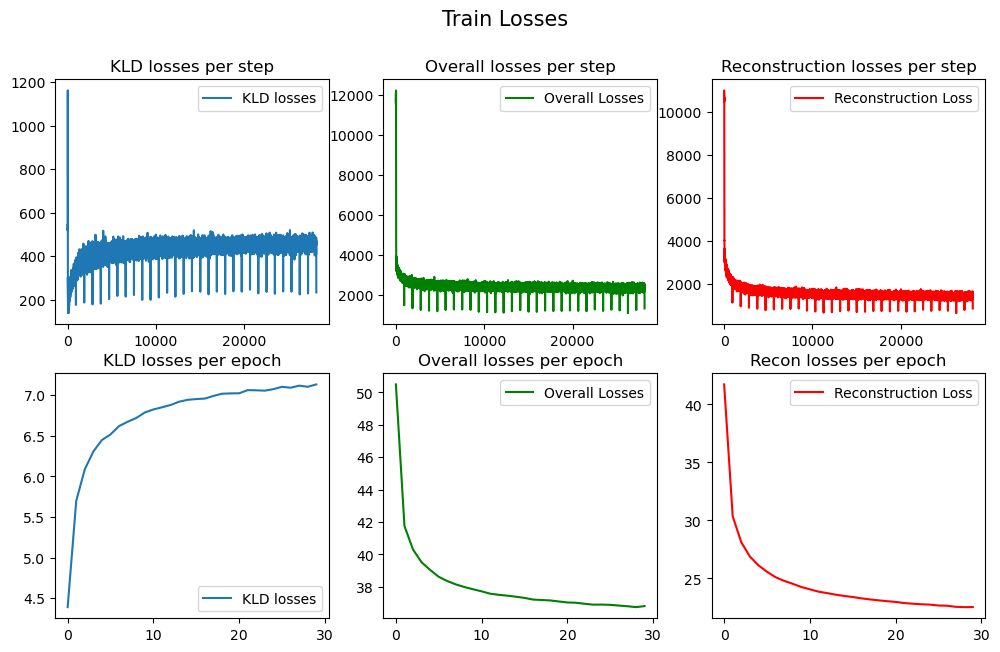

In [13]:
# *CODE FOR PART 1.2a IN THIS CELL*
import matplotlib.pyplot as plt

# plot
# fig, ax = plt.subplots()
fig, ax = plt.subplots(2, 3, )
# fig.set_size_inches(10, 5)
ax[0, 0].plot(torch.tensor(kld_losses).cpu(), label='KLD losses')
ax[0, 0].title.set_text("KLD losses per step")
ax[0, 1].plot(torch.tensor(losses).cpu(), color='green', label='Overall Losses')
ax[0, 1].title.set_text("Overall losses per step")
ax[0, 2].plot(torch.tensor(recon_losses).cpu(), color='red', label='Reconstruction Loss')
ax[0, 2].title.set_text("Reconstruction losses per step")

ax[0, 0].legend()
ax[0, 1].legend()
ax[0, 2].legend()

ax[1, 0].plot(torch.tensor(kld_losses_avg).cpu(), label='KLD losses')
ax[1, 0].title.set_text("KLD losses per epoch")
ax[1, 1].plot(torch.tensor(losses_avg).cpu(), color='green', label='Overall Losses')
ax[1, 1].title.set_text("Overall losses per epoch")
ax[1, 2].plot(torch.tensor(recon_losses_avg).cpu(), color='red', label='Reconstruction Loss')
ax[1, 2].title.set_text("Recon losses per epoch")

ax[1, 0].legend()
ax[1, 1].legend()
ax[1, 2].legend()
fig.set_size_inches(12, 7)

fig.suptitle('Train Losses', fontsize=15)
plt.show()



/tmp/ipykernel_3516059/2100551609.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ax[0].plot(torch.tensor(kld_losses_test_avg).cpu(), label='KLD losses')
/tmp/ipykernel_3516059/2100551609.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ax[1].plot(torch.tensor(losses_test_avg).cpu(), color='green', label='Overall Losses')
/tmp/ipykernel_3516059/2100551609.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ax[2].plot(torch.tensor(recon_losses_test_avg).cpu(), color='red', label='Reconstruction Loss')


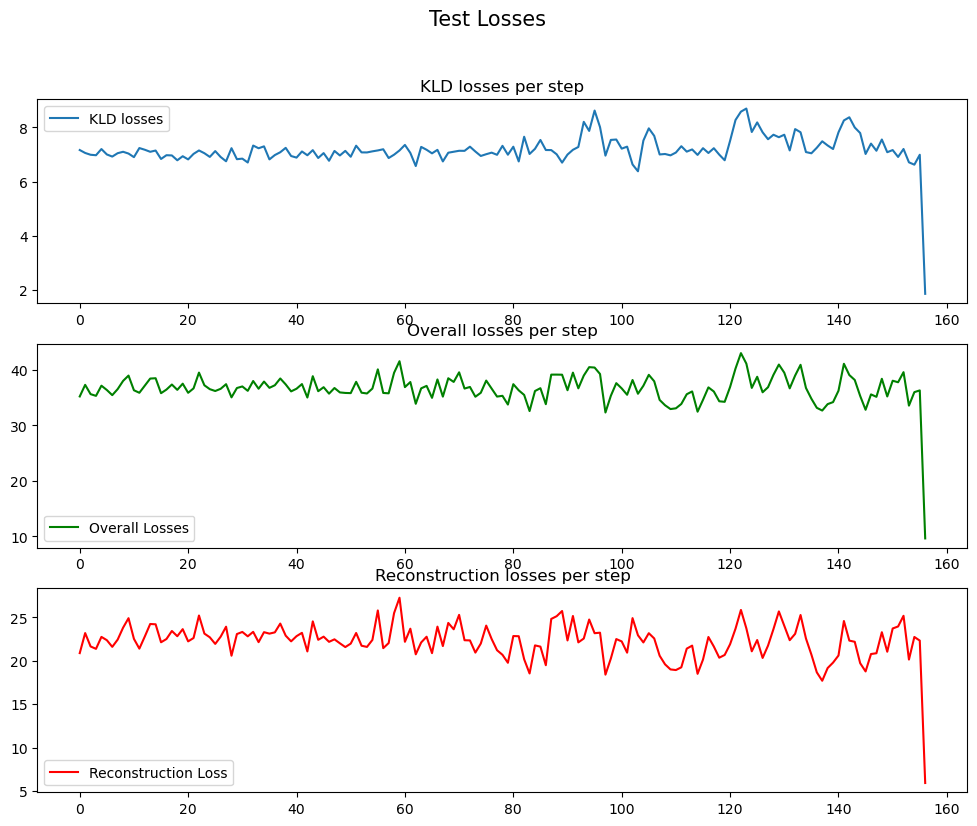

In [14]:
fig, ax = plt.subplots(3)

ax[0].plot(torch.tensor(kld_losses_test_avg).cpu(), label='KLD losses')
ax[0].title.set_text("KLD losses per step")
ax[1].plot(torch.tensor(losses_test_avg).cpu(), color='green', label='Overall Losses')
ax[1].title.set_text("Overall losses per step")
ax[2].plot(torch.tensor(recon_losses_test_avg).cpu(), color='red', label='Reconstruction Loss')
ax[2].title.set_text("Reconstruction losses per step")

ax[0].legend()
ax[1].legend()
ax[2].legend()

fig.set_size_inches(12, 9)

fig.suptitle('Test Losses', fontsize=15)
plt.show()



## Part 1.2b: Samples and Reconstructions (6 Points)
Visualize a subset of the images of the test set and their reconstructions **as well as** a few generated samples. Most of the code for this part is provided. You only need to call the forward pass of the model for the given inputs (might vary depending on your implementation).

For reference, here's [some samples from our VAE](https://imgur.com/NwNMuG3).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input images
--------------------------------------------------
Reconstructed images
--------------------------------------------------
Generated Images
--------------------------------------------------


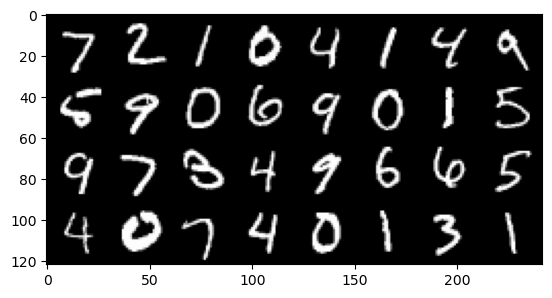

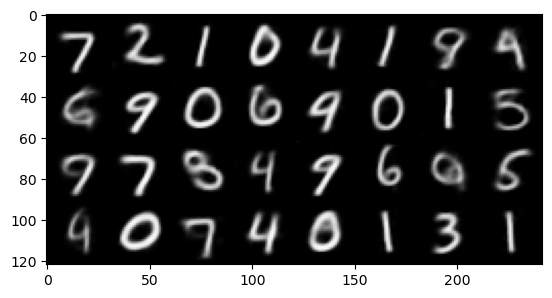

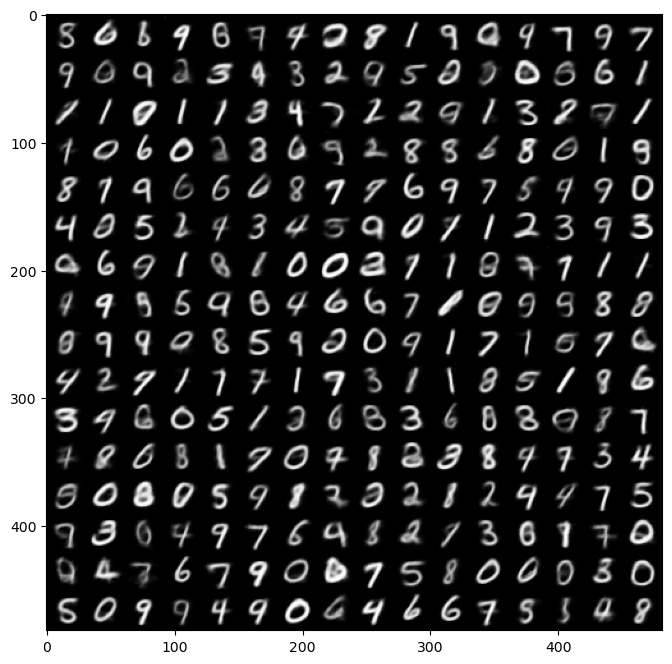

In [15]:
# *CODE FOR PART 1.2b IN THIS CELL*

# load the model
print('Input images')
print('-'*50)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]
# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

print('Reconstructed images')
print('-'*50)
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set

    #######################################################################
    #                       ** START OF YOUlogvarR CODE **
    #######################################################################
    recon_batch, _, _, _ = model(fixed_input.to(device))
    #######################################################################
    #                       ** END OF YOUR CODE **
    #######################################################################

    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            value_range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)

print('Generated Images')
print('-'*50)
model.eval()
n_samples = 256
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    samples = model.decode(z)
    #######################################################################
    #                       ** END OF YOUR CODE **
    #######################################################################

    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                            value_range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)



### Discussion
Provide a brief analysis of your loss curves and reconstructions:
* What do you observe in the behaviour of the log-likelihood loss and the KL loss (increasing/decreasing)?
* Can you intuitively explain if this behaviour is desirable?
* What is posterior collapse and did you observe it during training (i.e. when the KL is too small during the early stages of training)?
    * If yes, how did you mitigate it? How did this phenomenon reflect on your output samples?
    * If no, why do you think that is?

**YOUR ANSWER**

The log-liklihood los and the KL loss both decrease in my case and then converge to a single value with periodic. This shows that the produced dataset from the encoder and the actual dataset have fairly diverse examples allowing the VAE to learn more. If these values were to drop too much or be unstable, it would interfere in the training of the VAE since it would not have any single stimulus in terms of learning and gradient descent and would keep going back and forth. This also gives a change of possibe posterior collapse, which would be hard to remove if it happened in training. If the model starts experiencing posterior collapse, it will continue to experience it in the remaining span of the training. 

Due to my high value of $\beta$ the KL loss decreases significantly suddenly, however since the beta still remains in a viable range it continues to learn efficiently. The loss does not vanish or suddenly tend to very large values hence also signifying that the gernerated samples are fairly different from the training samples ensuring that the model continues and is able to learn.

In the beginning of my training I experienced a very small KL loss. This was due to the prior distribution and the genrated distribution being too small. This caused posterior collapse and the VAE failed to learn or extract any useful information from the dataset hence proving pointless.
The output samples as a result were all the same for all inputs and were pointless with lot of noice and fairly circular signifying to a very general learning without any intracacies being learnt from the data.
I was able to mitigate this by using appropriate values of beta that were an accurate representation for my VAE model.

---
<h2> Part 1.3 (11 points) <h2/>

Qualitative analysis of the learned representations

In this question you are asked to qualitatively assess the representations that your model has learned. In particular:

a. Dimensionality Reduction of learned embeddings

b. Interpolating in the latent space

## Part 1.3a: T-SNE on Embeddings (7 Points)
Extract the latent representations of the test set and visualize them using [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)  [(see implementation)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). You can use a T-SNE implementation from a library such as scikit-learn.

We've provided a function to visualize a subset of the data, but you are encouraged to also produce a matplotlib plot (please use different colours for each digit class).

In [ ]:
# *CODE FOR PART 1.3a IN THIS CELL

In [203]:
# Interactive Visualization - Code Provided
test_dataloader = DataLoader(test_dat, 10000, shuffle=False)
""" Inputs to the function are
        z_embedded - Embedded X, Y positions for every point in test_dataloader
        test_dataloader - dataloader with batchsize set to 10000
        num_points - number of points plotted (will slow down with >1k)
"""
model.eval()
with torch.no_grad():
    for i, (x, y) in enumerate(test_dataloader):
        print("Encoding")
        mu, log_var = model.encode(x.to(device))
        z_embedded = model.reparametrize(mu, log_var).cpu().numpy()

plot_tsne(z_embedded, test_dataloader, num_points=1000, darkmode=False)


Encoding


TypeError: altair.vegalite.v5.schema.core.SelectionParameter() got multiple values for keyword argument 'value'

In [206]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

def make_plot(f, label, n_points, b):
    features = f[0:n_points, ]
    tsne = TSNE(n_components=2, perplexity=2,  init='pca', random_state=0)
    tsne_features = tsne.fit_transform(features)
    df = pd.DataFrame(data = tsne_features, columns = ['PCA1', 'PCA2'])
    df['Label'] = label[0:n_points]
    df['PCA1'] = tsne_features[:,0]
    df['PCA2'] = tsne_features[:,1]
    sns.scatterplot(x = 'PCA1', y='PCA2', hue='Label', data=df, palette='dark',  alpha=0.7,
                    legend='full').set_title('TSNE with beta: ' + str(b))
    plt.tight_layout()
    plt.show()    

Encoding


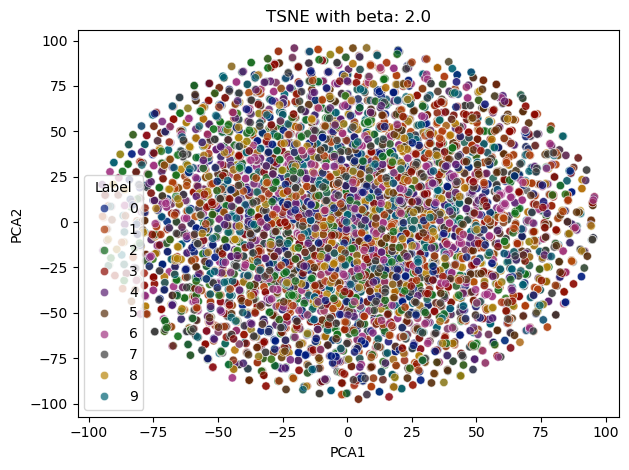

In [207]:
# Custom Visualizations
test_dataloader = DataLoader(test_dat, 10000, shuffle=False)
model.eval()
z_embedded = []
with torch.no_grad():
    for (x, y) in test_dataloader:
        print("Encoding")
        mu, log_var = model.encode(x.to(device))
        z_embedded = model.reparametrize(mu, log_var).cpu().numpy()
z_embedded = np.array(z_embedded).reshape(-1,64)
make_plot(z_embedded, y, 10000, 2.00)


### Discussion
What do you observe? Discuss the structure of the visualized representations.
* What do you observe? What role do the KL loss term and $\beta$ have, if any, in what you observe (multiple matplotlib plots may be desirable here)?
    * Consider Outliers
    * Counsider Boundaries
    * Consider Clusters
* Is T-SNE reliable? What happens if you change the parameters (don't worry about being particularly thorough). [This link](https://distill.pub/2016/misread-tsne/) may be helpful.

Note - If you created multiple plots and want to include them in your discussion, the best option is to upload them to (e.g.) google drive and then embed them via a **public** share link. If you reference local files, please include these in your submission zip, and use relative pathing if you are embedding them (with the notebook in the base directory)

**YOUR ANSWER**

As explained previously, I prioritised the visual clarity of the produced digits from my VAE and not the clustering in the TSNE hence the results produced are very undistinguiushable. 

As I increase the $\beta$ in the loss function, the clarity of the produced images decreases but the overall clusters are more visual and have cler boundaries. They are distinct and show clear seperations between each number and cluster. While there are sum outliers in that case also which signify the numbers of figures that are unclear to the model and fails to learn. However these outliers also are a sign of lack of overfitting which is always a good sign in a machne learning model.

TSNE is fairly reliable in different applications, however not very useful in my application. It seemed that the results produced wer counterintuitive in my opinion and should either be represented differently or I may be missing some insight or intuition within the use of TSNE.
It may also be possible that the representation of the latent dimensions and output space may require more dimensions to be clear while I have used only 2 dimensions.

## Part 1.3b: Interpolating in $z$ (4 Points)
Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from on digit to the other?

_hint: Locate the positions in latent space of 2 data points (maybe a one and an eight). Then sample multiple latent space vectors along the line which joins the 2 points and pass them through the decoder._


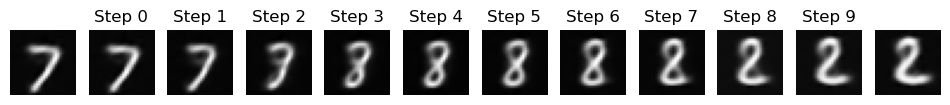

In [179]:
# CODE FOR PART 1.3b IN THIS CELL
def show_decoded(embedding): 
    return model.decode(embedding.to(device)).detach().cpu().squeeze([0,1])

for (x, y) in test_dataloader:
    n1 = x[y == 2][0]
    n2 = x[y == 7][0]

n1 = n1.unsqueeze(0)
n2 = n2.unsqueeze(0)

mu, log_var = model.encode(n1.clone().detach().to(device))
e1 = model.reparametrize(mu, log_var).detach().cpu()

mu, log_var = model.encode(n2.clone().detach().to(device))
e2 = model.reparametrize(mu, log_var).detach().cpu()

difference = e1 - e2
step_factor = difference / 10

fig, ax = plt.subplots(1, 12)

ax[0].imshow(show_decoded(e2), cmap='gray')
ax[0].axis('off')
for i in range(10):
    # interpolated_embedding += step_factor
    temp = e2 + i * step_factor
    inp_x = torch.tensor(np.array(temp.detach().cpu())).cpu()
    ax[i + 1].imshow(show_decoded(inp_x), cmap='gray')
    ax[i + 1].title.set_text(f'Step {i}')
    ax[i + 1].axis('off')
ax[-1].imshow(show_decoded(e1), cmap='gray')
ax[-1].axis('off')

fig.set_size_inches(12, 9)
plt.show()

### Discussion
What did you observe in the interpolation? Is this what you expected?
* Can you relate the interpolation to your T-SNE visualization

**YOUR ANSWER**

In the above provided example, the interpolation presents a very expected result. When I trained the system with a lower $\beta$, the produced clusters were clear and the interpolation created was also clear between two adjacent clusters. It was evident that the embeddings were translating from one cluster to the other.

But in our given example with a higher $\beta$, we see that the TSNE clusters produced are very mixed and entangled. This translates into the interpolation also where the transition is clear but it also shows other digits in the number. In the provided example, we go from 7 to 2, but in the process see a hint of 3 in step 2 and a very clear 8 in step 6. This shows that the clusters are very entangled and even though we get to the correct output, we see alot of other meaningful results in the process. Furthermore, a lower $\beta$ model could very clearly step by step interpolate 1 digit to the other while my example does not do it as clearly.

# Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures and tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, you should provide us with:

- your best trained model (which we will be able to load and run),
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ we have provided you with (train for a number of epochs and make sure there is no mode collapse),
- plots with the losses for the discriminator $D$ and the generator $G$ as the training progresses and explain whether your produced plots are theoretically sensible and why this is (or not) the case.
- a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explanations of what you did in order to cope with mode collapse.

## Part 2.1 (30 points)
**Your Task**:

a. Implement the DCGAN architecture.

b. Define a loss and implement the Training Loop

c. Visualize images sampled from your best model's generator ("Extension" Assessed on quality)

d. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).


_Clarification: You should not be worrying too much about getting an "optimal" performance on your trained GAN. We want you to demonstrate to us that you experimented with different types of DCGAN variations, report what difficulties transpired throughout the training process, etc. In other words, if we see that you provided us with a running implementation, that you detail different experimentations that you did before providing us with your best one, and that you have grapsed the concepts, you can still get good marks. The attached model does not have to be perfect, and the extension marks for performance are only worth 10 points._

In [78]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import torch.nn.functional as F
import matplotlib.pyplot as plt

mean = torch.Tensor([0.4914, 0.4822, 0.4465])
std = torch.Tensor([0.247, 0.243, 0.261])
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x, channels=None, w=None ,h=None, resize = False):

    x = unnormalize(x)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'CW_GAN'):
    os.makedirs(content_path/'CW_GAN')

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

Using cuda


### Part 2.1a: Implement DCGAN (8 Points)
Fill in the missing parts in the cells below in order to complete the Generator and Discriminator classes. You will need to define:

- The hyperparameters
- The constructors
- `decode`
- `discriminator`

Recomendations for experimentation:
- use the architecture that you implemented for the Autoencoder of Part 1 (encoder as discriminator, decoder as generator).
- use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions.
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`).
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

Try to follow the common practices for CNNs (e.g small kernels, max pooling, RELU activations), in order to narrow down your possible choices.

<font color="red">**Your model should not have more than 25 Million Parameters**</font>

The number of epochs that will be needed in order to train the network will vary depending on your choices. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture. You don't need to train the network to an extreme if you don't have the time.

#### Data loading

In [4]:
batch_size = 64  # change that

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=mean, std=std),
])
# note - data_path was initialized at the top of the notebook
cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=batch_size)
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


We'll visualize a subset of the test set:

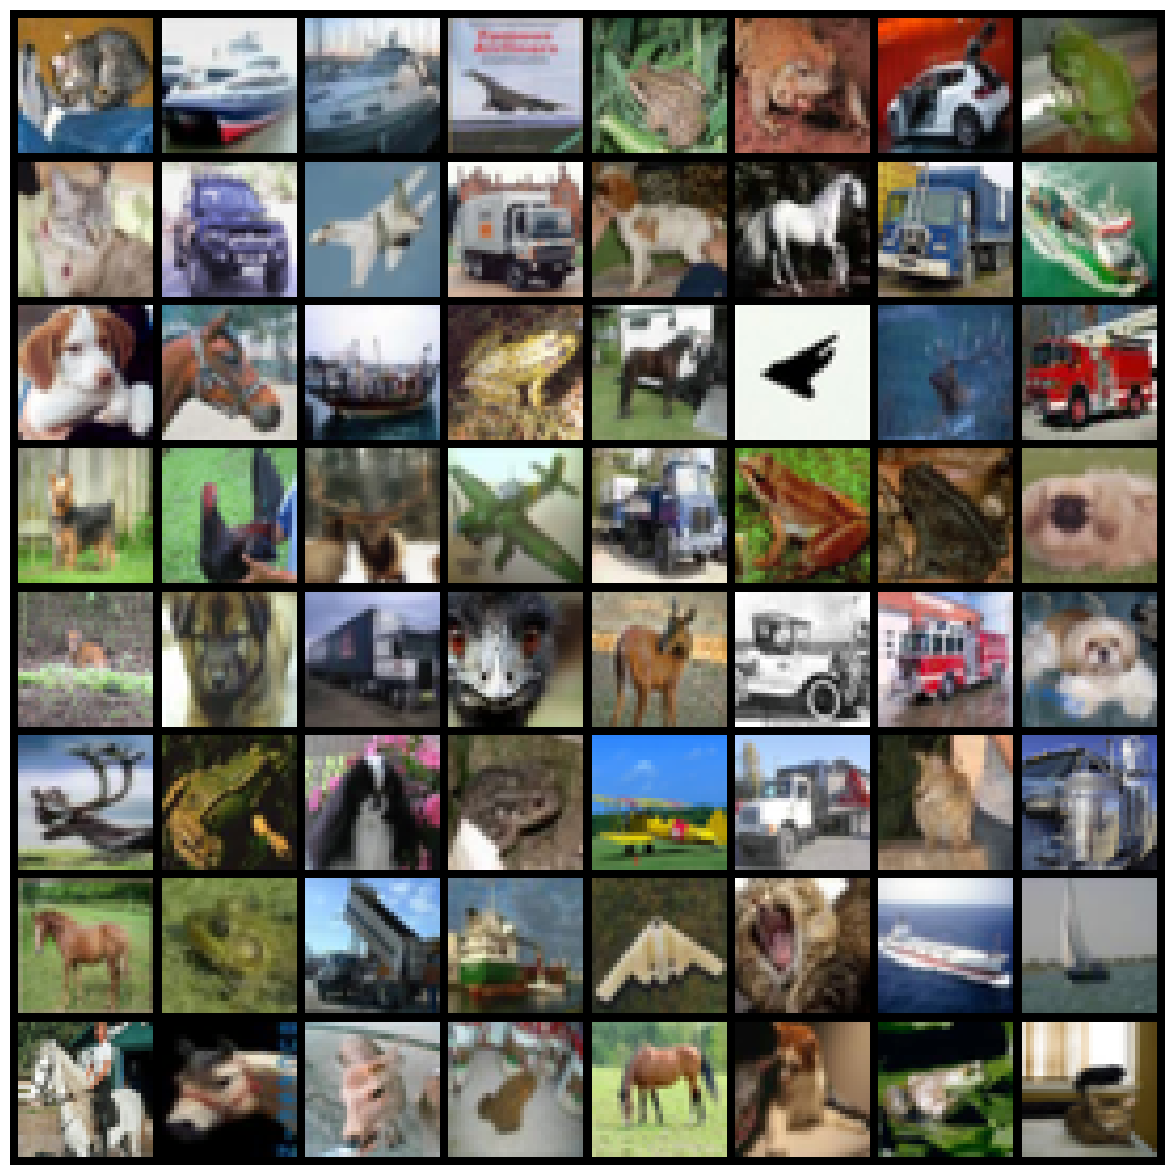

In [5]:
samples, _ = next(iter(loader_test))

samples = samples.cpu()
samples = make_grid(denorm(samples), nrow=8, padding=2, normalize=False,
                        value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize = (15,15))
plt.axis('off')
show(samples)

#### Model Definition
Define hyperparameters and the model

In [13]:
!pip install torch-summary

ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/vol/bitbucket/nuric/docenv_22.04/lib/python3.10/site-packages/torchsummary'
Check the permissions.



In [79]:
# *CODE FOR PART 2.1 IN THIS CELL*

# Choose the number of epochs, the learning rate
# and the size of the Generator's input noise vetor.

num_epochs = 50
learning_rate = 0.0001
latent_vector_size = 128

# Other hyperparams
d_learning_rate = 0.001
g_learning_rate = 0.001


In [7]:
# *CODE FOR PART 2.1 IN THIS CELL*

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.g = nn.Sequential(
            nn.ConvTranspose2d(latent_vector_size, 256, kernel_size=6, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 1 x 64 ---> 256 x 32 x 32

            nn.ConvTranspose2d( 256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 256 x 32 x 32 ---> 128 x 32 x 32
            
            nn.ConvTranspose2d( 128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 128 x 32 x 32 ---> 64 x 32 x 32
            
            nn.ConvTranspose2d( 64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # 64 x 32 x 32 ---> 3 x 32 x 32
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    # You can modify the arguments of this function if needed
    def forward(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.g(z)
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################
        return out


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.d = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 3 x 32 x 32 ---> 

            nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.Sigmoid()
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    # You can modify the arguments of this function if needed
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.d(x)
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

        return out


<h2> Initialize Model and print number of parameters </h2>

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [80]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [81]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 1838976
Generator(
  (g): Sequential(
    (0): ConvTranspose2d(128, 256, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


Total number of parameters in Discriminator is: 663296
Discriminator(
  (d): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), paddi

### Part 2.1b: Training the Model (12 Points)

#### Defining a Loss

In [10]:
# You can modify the arguments of this function if needed
def loss_function(out, label):
    loss = nn.BCELoss()
    return loss(out, label)

<h3>Choose and initialize optimizers</h3>

In [82]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=d_learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=g_learning_rate, betas=(beta1, 0.999))


<h3> Define fixed input vectors to monitor training and mode collapse. </h3>

In [83]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
# Additional input variables should be defined here

#### Training Loop

Complete the training loop below. We've defined some variables to keep track of things during training:
* errD: Loss of Discriminator after being trained on real and fake instances
* errG: Loss of Generator
* D_x: Output of Discriminator for real images
* D_G_z1: Output of Discriminator for fake images (When Generator is not being trained)
* D_G_z2: Output of Discriminator for fake images (When Generator is being trained)

In [85]:
train_losses_G = []
train_losses_D = []

# <- You may wish to add logging info here
for epoch in range(num_epochs):
    train_loss_D = 0
    train_loss_G = 0
    # <- You may wish to add logging info here
    with tqdm.tqdm(loader_train, unit="batch") as tepoch:
        for i, data in enumerate(tepoch):
            #######################################################################
            #                       ** START OF YOUR CODE **
            #######################################################################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

            # train with real
            model_D.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), 1, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = model_D(real_cpu)
            output = output.view(-1)
            # Calculate loss on all-real batch
            errD_real = loss_function(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake
            # Generate batch of latent vectors
            noise = torch.randn(b_size, latent_vector_size, 1, 1, device=device)
            # Generate fake image batch with G
            fake = model_G(noise)
            label.fill_(0)
            # Classify all fake batch with D
            output = model_D(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = loss_function(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            train_loss_D += errD.item()
            # Update D
            optimizerD.step()

            # (2) Update G network: maximize log(D(G(z)))
            model_G.zero_grad()
            label.fill_(1)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = model_D(fake).view(-1)
            # Calculate G's loss based on this output
            errG = loss_function(output, label)
            train_loss_G += errG.item()
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
            #######################################################################
            #                       ** END OF YOUR CODE **
            #######################################################################
            # Logging
            if i % 50 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(D_G_z=f"{D_G_z1:.3f}/{D_G_z2:.3f}", D_x=D_x,
                                  Loss_D=errD.item(), Loss_G=errG.item())

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()).float(), content_path/'CW_GAN/real_samples.png')
    with torch.no_grad():
        fake = model_G(fixed_noise)
        save_image(denorm(fake.cpu()).float(), str(content_path/'CW_GAN/fake_samples_epoch_%03d.png') % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))

# save  models
# if your discriminator/generator are conditional you'll want to change the inputs here
torch.jit.save(torch.jit.trace(model_G, (fixed_noise)), content_path/'CW_GAN/GAN_G_model.pth')
torch.jit.save(torch.jit.trace(model_D, (fake)), content_path/'CW_GAN/GAN_D_model.pth')

Epoch 49: 100%|███████████| 782/782 [00:23<00:00, 33.46batch/s, D_G_z=0.043/0.069, D_x=0.894, Loss_D=0.174, Loss_G=3.73]


## Part 2.1c: Results (10 Points)
This part is fairly open-ended, but not worth too much so do not go crazy. The table below shows examples of what are considered good samples. Level 3 and above will get you 10/10 points, level 2 will roughly get you 5/10 points and level 1 and below will get you 0/10 points.

<table><tr>
<td>
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=18aWqRAnAVTRDY52y1yHSCdqSxUFRKOS9" width="%30">
    <br>
    <em style="color: grey">Level 1</em>
  </p>
</td>
<td>
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=1ymO2-jGAvWeUR2kaj_LxQcGYF1RWNRnw" width="%30">
    <br>
    <em style="color: grey">Level 2</em>
  </p>
</td>
<td>
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=13SW62ekW32NMYtfcdm_dCJJ3ZMOZEZAJ" width="%30">
    <br>
    <em style="color: grey">Level 3</em>
  </p>
</td>
</tr></table>

### Generator samples

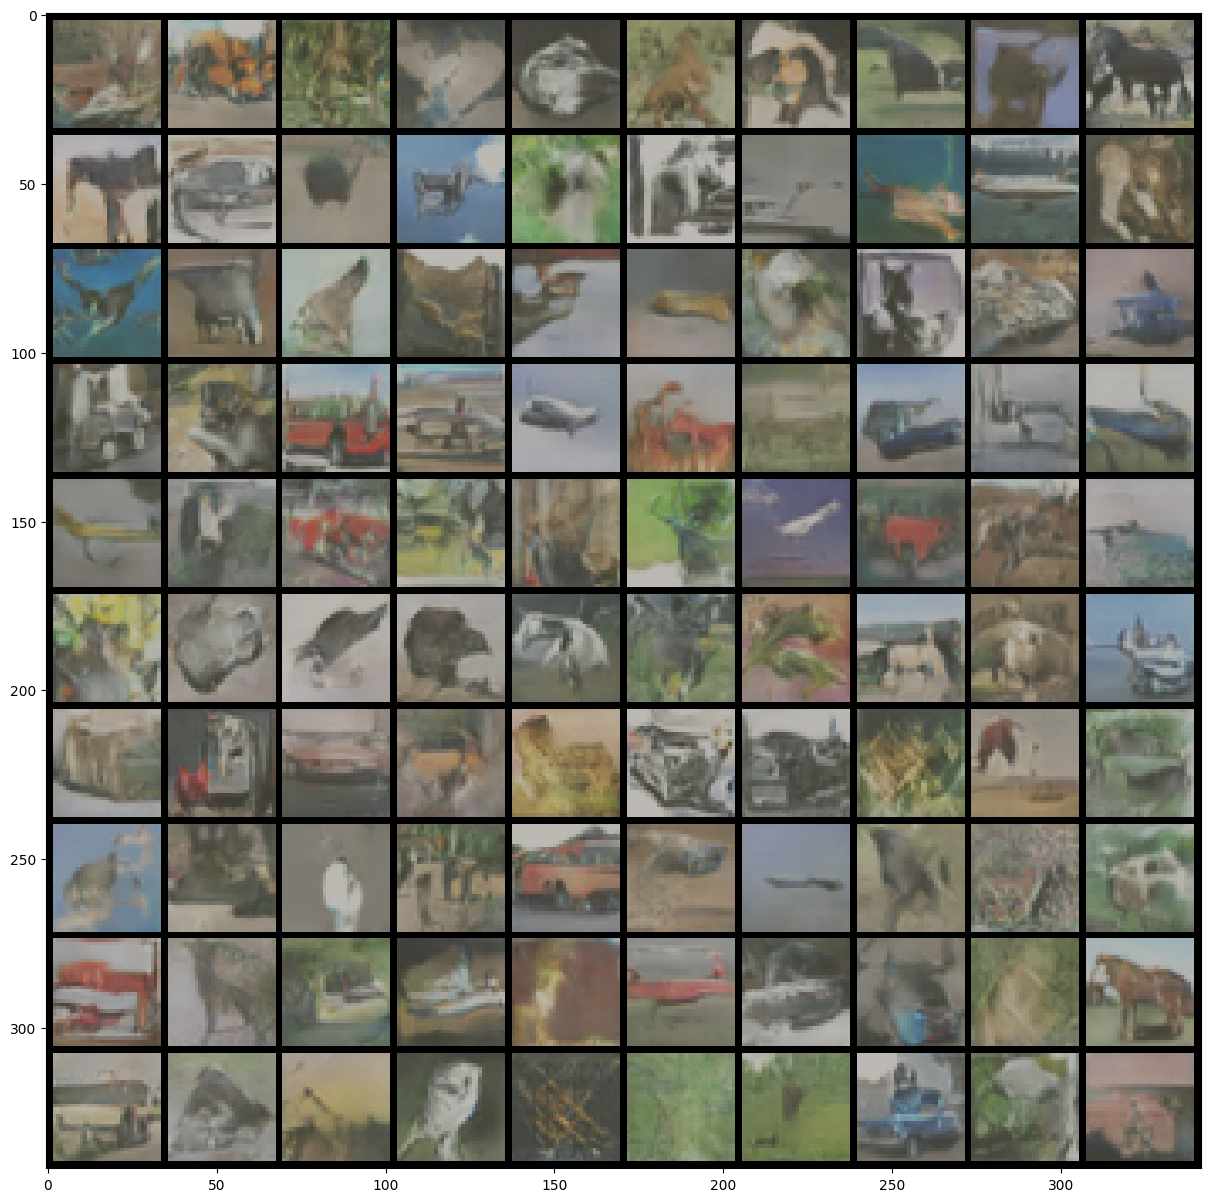

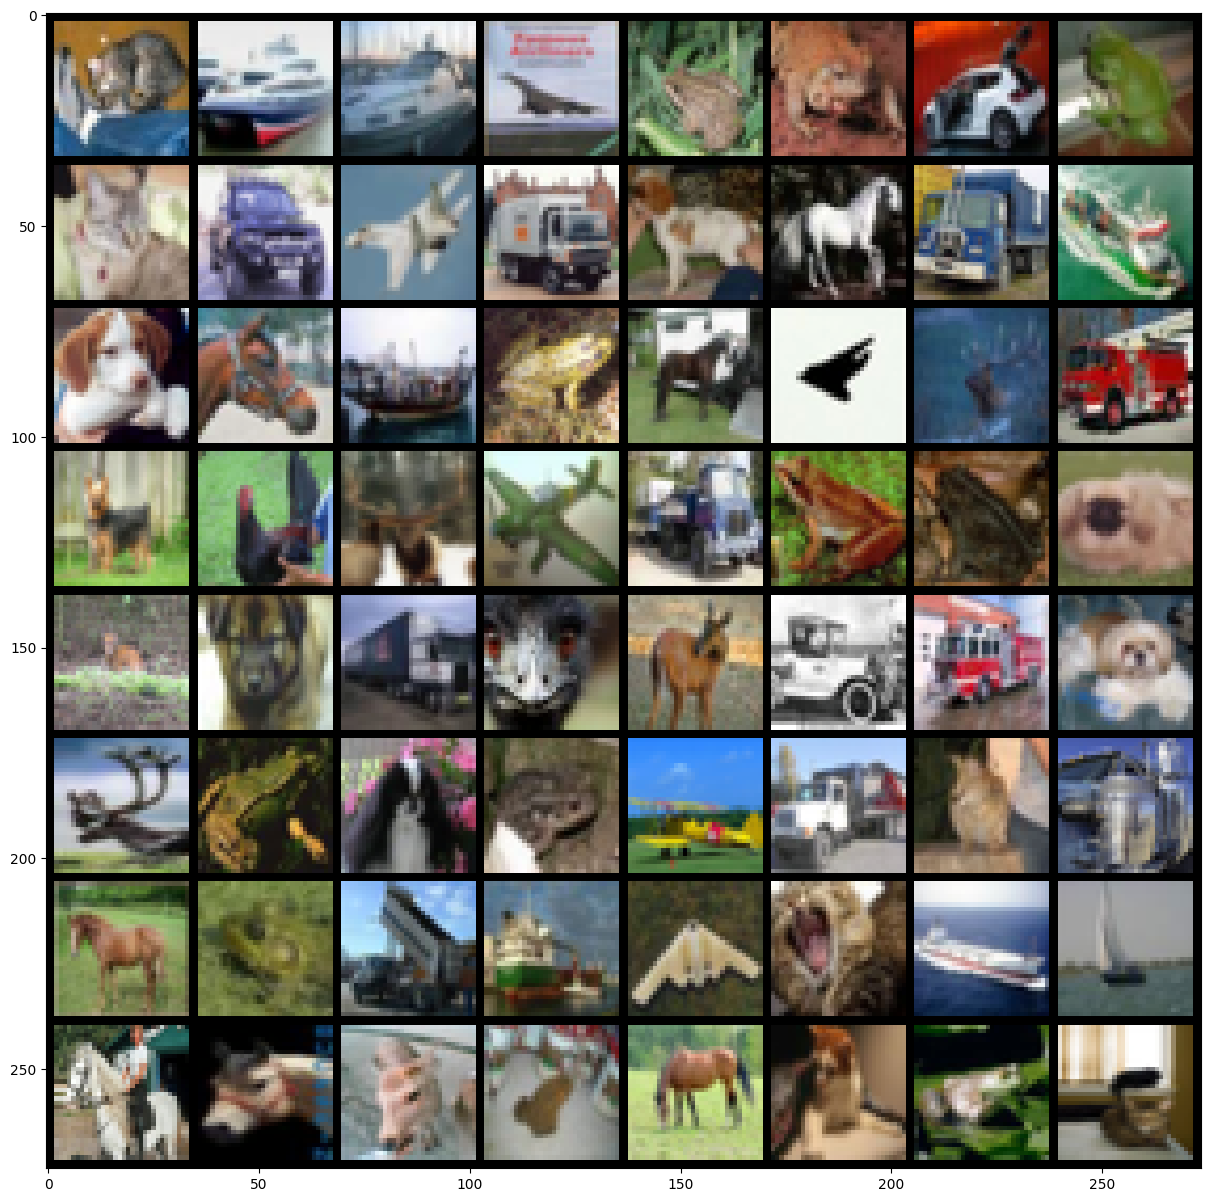

In [88]:
input_noise = torch.randn(100, latent_vector_size, 1, 1, device=device)
with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:100], nrow=10, padding=2, normalize=False,
                        value_range=None, scale_each=False, pad_value=0)
    plt.figure(figsize=(15,15))
    save_image(generated, content_path/'CW_GAN/Teaching_final.png')
    show(generated) # note these are now class conditional images columns rep classes 1-10

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:64, :, :, :]
# visualize the original images of the last batch of the test set for comparison
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
show(img)

## Part 2.1d: Engineering Choices (10 Points)

Discuss the process you took to arrive at your final architecture. This should include:

* Which empirically useful methods did you utilize
* What didn't work, what worked and what mattered most
* Are there any tricks you came across in the literature etc. which you suspect would be helpful here

**Your Answer**

I arrived at the final architecture rather fatefully where the first architecture I tried seemed to work perfectly and any major changes to it were limiting my training process. (I ran into the problem of my model being too big and being unable to train it on the GPU for both the DCGAN and VAE, this seems to be a unique problem to me. However I found that over engineering it and trying to fix it for too long did not help me in any meaningful way and the relatively simple architecture I used worked fairly well).

The Discriminator and Generator are both equally complex in my given case. I did venture into using a more complicated generator and a simpler discriminator which seems to be a possible solution, but given the dataset's size and simplicity, it did not seem to give me a very big edge. I did find some improvement in using a discriminator with 2 to 3 more layers, with the peak number of channels being up to 1024 to 2048, however the tradeoff was training time. Hence I opted to use the simple architecture instead of a more complicated one as a design decision to prioritise training time over perfect results.

One thing that did not work was using fully connected layers of equal sizes. Example 2 consecutive layers of 256. Furthermore, changing batch sizes also did not significantly change the results.

Using differnet activation functions in the final layers compared to the other layers did produce clearer results. Specifically using tanh produced results that were clearer. Furthermore the usage of batch normalization seemed to provide a smoother transition overall on the loss curves hence I used batch normalization on all layers of discriminator and generator except for their final layers. This was also suggested in the literature.

Another possible trick from the literature is using different learning rates for discriminator and generator, however that did not prove very advantageous in my case. I used the same learning rate for both in the given model which gave me the best results while I did test on multiple variations. Another trick I wanted to use but could not implement was input augmentation.

## Part 2.2: Understanding GAN Training (5 points)


### Loss Curves
**Your task:**


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

Make sure that the version of the notebook you deliver includes these results.

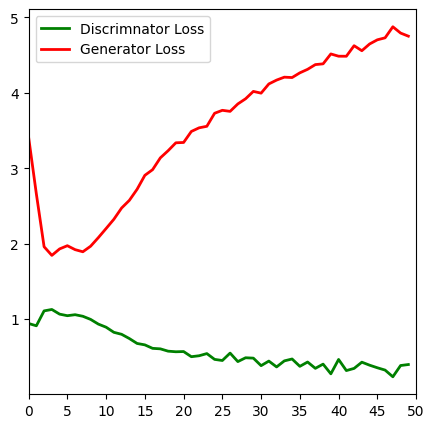

In [98]:
# ANSWER FOR PART 2.2 IN THIS CELL*
# import matplotlib.pyplot as plt
# import numpy as np

# plt.style.use('_mpl-gallery')

# make data
y_D = train_losses_D
y_G = train_losses_G

# plot
fig, ax = plt.subplots()

fig.set_size_inches(5, 5)

ax.plot(y_D, linewidth=2.0, color='green', label='Discrimnator Loss')
ax.plot(y_G, linewidth=2.0, color='red', label='Generator Loss')
ax.legend()
ax.set(xlim=(0, 50), xticks=np.arange(0, 51, 5))
plt.show()


### Discussion

Do your loss curves look sensible? What would you expect to see and why?

**YOUR ANSWER**

Due to the nature of GAN models overall, the generator and discrimnator losses are a counter intuitive way of measuring performance. While some research papers have mentioned the possibility of using other metrics like likelihood, I could not within the timeframe find any proper conclusive quantifiable value which I could use to show the performance of my DCGAN. 

The problem with the loss curves of a discriminator and generator is that they tend to bounce around alot and remain unstable. This is because when the generator or discriminator are fighting towards each other, hence if one learns, the other sees a sudden spike in its loss, this results in the later one to conpensate and try to learn to diminish the loss, and when it succeeds in minimizing the loss again, it causes a spike in the loss of the other. This cycle continues to a point where they both converge to a certain value.
Since we are using a DCGAN instead of a vanilla GAN, the batch normalization and convolution help our loss to be relatively smoother, regardless we can see spikes in the plots. 

Hence due to the nature of the problem, we cannot extract alot of meaningful information from the loss curves, in terms of quantifiable metrics, however there is an expectation that the generator and discriminator losses will converge to a single value with lesser unstability in the loss curves signifying that both the generator and discrimnator have learned everything there was to learn. We can see that phenomena in the above graph. The two loss curves seem to be converging to singular values and had we icreased the epochs, they would converge to a single value in a more visual sense. However, I decided to limit to 50 epochs for multiple reasons. Firstly, continuing the training after a certain limit even with good learning rates can result into mode collapse. The graphs provided below which were achieved during hyper parameter tuning show that and was witnessed in my qualitative testing. Furthermore, there is a point of diminishing returns in terns of the epochs of DCGAN training where I started seeing that the generated samples were not improving much but the colors with unsaturated and I didn't want to reach a point where there would be a sudden mode collapse.

### 
The following code is for hyper parameter searching and is provided as proof of working and clarification. It does not need to be ran for marking 

In [69]:
from contextlib import redirect_stdout

def save_graph(y_D, y_G, filepath='./outp/'):
    x = np.linspace(0, 10, 100)
    y = 4 + 2 * np.sin(2 * x)

    fig, ax = plt.subplots()

    ax.plot(y_D, linewidth=2.0, color='green', label='Discrimnator Loss')
    ax.plot(y_G, linewidth=2.0, color='red', label='Generator Loss')
    ax.legend()
    ax.set(xlim=(0, 50))

    # plt.show()
    plt.savefig(filepath + "/CW_GAN/graph.png")

In [75]:
def trainer(latent_vector_size_tuning= 128, g_learning_rate_tuning=0.001, d_learning_rate_tuning = 0.0001, num_epochs_tuning = 30):
    content_path_temp = './outp/' + str(d_learning_rate_tuning) + '_' + str(g_learning_rate_tuning)
    
    if not os.path.exists(content_path_temp):
        os.makedirs(content_path_temp)
    if not os.path.exists(content_path_temp + '/CW_GAN'):
        os.makedirs(content_path_temp+ '/CW_GAN')
    
    output_file = content_path_temp + '/out.txt'
    with open(output_file, 'w+') as f:
        with redirect_stdout(f):
            print("Training for the following params: ")
            print("\tGenerator learning rate: ", g_learning_rate_tuning)
            print("\tDiscriminator learning rate: ", d_learning_rate_tuning)
            print("\tEpochs: ", num_epochs_tuning)
            print("\n\n")
            
            #weights initialization
            use_weights_init = True
            model_G = Generator().to(device)
            if use_weights_init:
                model_G.apply(weights_init)
            params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
            print("Total number of parameters in Generator is: {}".format(params_G))
            print(model_G)
            print('\n')

            model_D = Discriminator().to(device)
            if use_weights_init:
                model_D.apply(weights_init)
            params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
            print("Total number of parameters in Discriminator is: {}".format(params_D))
            print(model_D)
            print('\n')

            print("Total number of parameters is: {}".format(params_G + params_D))
            
            beta1 = 0.5
            optimizerD = torch.optim.Adam(model_D.parameters(), lr=d_learning_rate_tuning, betas=(beta1, 0.999))
            optimizerG = torch.optim.Adam(model_G.parameters(), lr=g_learning_rate_tuning, betas=(beta1, 0.999))
            fixed_noise = torch.randn(batch_size, latent_vector_size_tuning, 1, 1, device=device)
            
            
            train_losses_G = []
            train_losses_D = []
            
            for epoch in range(num_epochs_tuning):
                train_loss_D = 0
                train_loss_G = 0
                # <- You may wish to add logging info here
                with tqdm.tqdm(loader_train, unit="batch") as tepoch:
                    for i, data in enumerate(tepoch):
                        #######################################################################
                        #                       ** START OF YOUR CODE **
                        #######################################################################
                        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

                        model_D.zero_grad()
                        real_cpu = data[0].to(device)
                        b_size = real_cpu.size(0)
                        label = torch.full((b_size,), 1, dtype=torch.float, device=device)
                        output = model_D(real_cpu)
                        output = output.view(-1)
                        errD_real = loss_function(output, label)
                        errD_real.backward()
                        D_x = output.mean().item()

                        noise = torch.randn(b_size, latent_vector_size_tuning, 1, 1, device=device)
                        fake = model_G(noise)
                        label.fill_(0)
                        output = model_D(fake.detach()).view(-1)
                        errD_fake = loss_function(output, label)
                        errD_fake.backward()
                        D_G_z1 = output.mean().item()
                        errD = errD_real + errD_fake
                        train_loss_D += errD.item()
                        optimizerD.step()

                        model_G.zero_grad()
                        label.fill_(1)  # fake labels are real for generator cost
                        output = model_D(fake).view(-1)
                        errG = loss_function(output, label)
                        train_loss_G += errG.item()
                        errG.backward()
                        D_G_z2 = output.mean().item()
                        optimizerG.step()
                        
                        torch.cuda.empty_cache()
                        # Logging
                        if i % 50 == 0:
                            tepoch.set_description(f"Epoch {epoch}")
                            tepoch.set_postfix(D_G_z=f"{D_G_z1:.3f}/{D_G_z2:.3f}", D_x=D_x,
                                              Loss_D=errD.item(), Loss_G=errG.item())

                if epoch == 0:
                    save_image(denorm(real_cpu.cpu()).float(), content_path_temp + '/CW_GAN/real_samples.png')
                with torch.no_grad():
                    fake = model_G(fixed_noise)
                    save_image(denorm(fake.cpu()).float(), content_path_temp + (str('/CW_GAN/fake_samples_epoch_%03d.png') % epoch))
                train_losses_D.append(train_loss_D / len(loader_train))
                train_losses_G.append(train_loss_G / len(loader_train))
            
            save_graph(y_D=train_losses_D, y_G=train_losses_G, filepath=content_path_temp)


Epoch 0:   0%|               | 3/782 [00:00<00:26, 29.50batch/s, D_G_z=0.426/0.001, D_x=0.395, Loss_D=1.69, Loss_G=6.88]

Working on:  ./outp/0.001_0.001/outp.txt


Epoch 0:   1%|               | 4/782 [00:00<00:24, 32.18batch/s, D_G_z=0.419/0.231, D_x=0.437, Loss_D=1.49, Loss_G=1.58]

moving to next
Working on:  ./outp/0.001_0.0001/outp.txt


Epoch 0:   1%|               | 4/782 [00:00<00:24, 31.29batch/s, D_G_z=0.491/0.004, D_x=0.523, Loss_D=1.51, Loss_G=5.73]

moving to next
Working on:  ./outp/0.001_0.0005/outp.txt


Epoch 0:   1%|                 | 4/782 [00:00<00:23, 32.51batch/s, D_G_z=0.607/0.000, D_x=0.581, Loss_D=1.62, Loss_G=23]

moving to next
Working on:  ./outp/0.005_0.005/outp.txt


Epoch 0:   1%|               | 4/782 [00:00<00:24, 32.30batch/s, D_G_z=0.502/0.275, D_x=0.544, Loss_D=1.44, Loss_G=1.42]

moving to next
Working on:  ./outp/0.005_0.0001/outp.txt


Epoch 0:   1%|                 | 4/782 [00:00<00:24, 32.38batch/s, D_G_z=0.465/0.002, D_x=0.62, Loss_D=1.19, Loss_G=6.3]

moving to next
Working on:  ./outp/0.005_0.0005/outp.txt


Epoch 49: 100%|███████████| 782/782 [00:24<00:00, 32.22batch/s, D_G_z=0.212/0.128, D_x=0.822, Loss_D=0.561, Loss_G=2.43]


moving to next


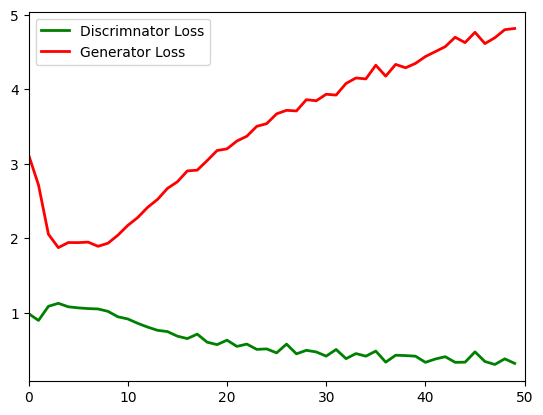

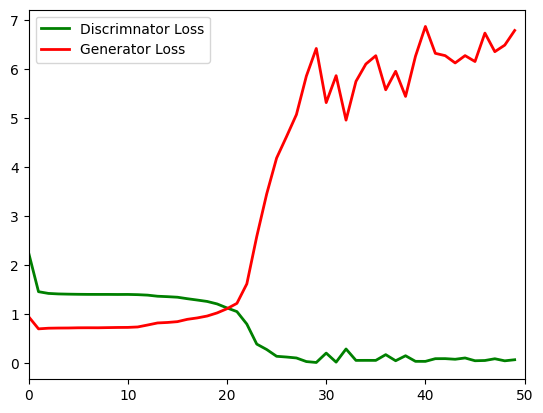

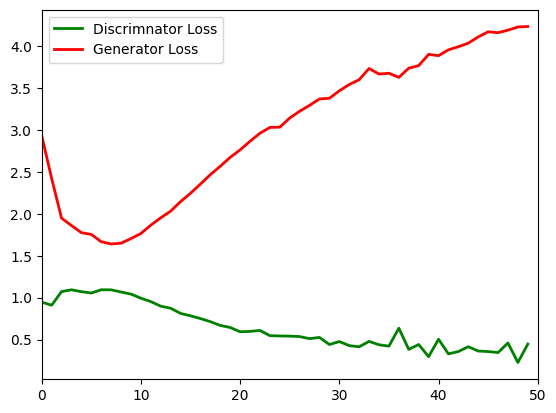

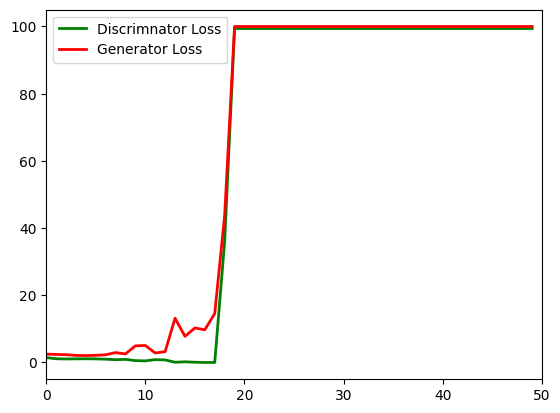

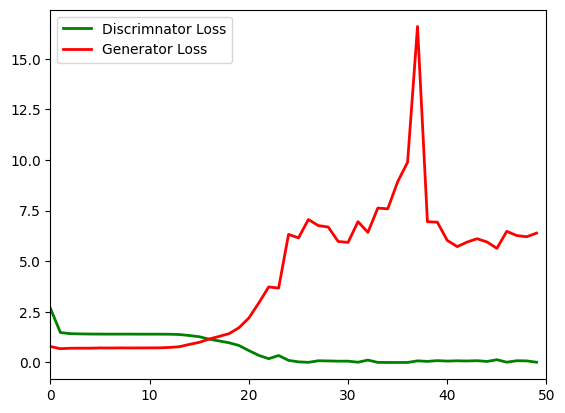

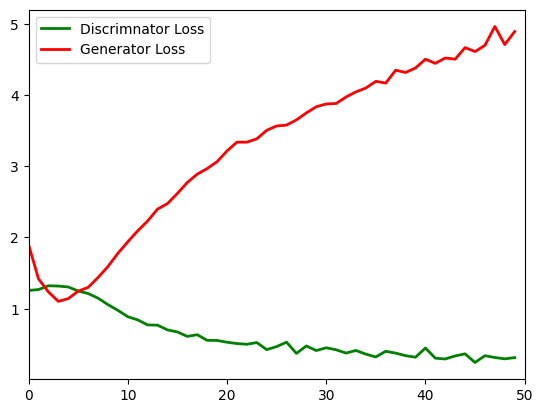

In [76]:
learning_pairs = [ (0.001, 0.001), (0.001, 0.0001), (0.001, 0.0005), (0.005, 0.005), (0.005, 0.0001), (0.005, 0.0005)]
epoch = 50

for index, (g_lr, d_lr) in enumerate(learning_pairs):
    path = "./outp/" + str(g_lr) + "_" + str(d_lr) + "/outp.txt" 
    print('Working on: ', path)
    trainer(d_learning_rate_tuning=d_lr, num_epochs_tuning=epoch, g_learning_rate_tuning=g_lr)
    print('moving to next')


## Part 2.3: Understanding Mode Collapse (5 points)
**Your task:**

Describe the what causes the phenomenon of Mode Collapse and how it may manifest in the samples from a GAN.

Based on the images created by your generator using the `fixed_noise` vector during training, did you notice any mode collapse? what this behaviour may be attributed to, and what did you try to eliminate / reduce it?

In [105]:
## Any additional code

### Discussion


<table><tr>
<td>
  <p align="center">
    <img alt="Mode Collapse" src="./fake_samples_epoch_049.png" width="%30">
    <br>
    <em style="color: grey">Mode Collapse seen during training</em>
  </p>
</td>
</tr></table>

**YOUR ANSWER**

While I did encounter mode collapse, it was not a prevalent problem during my hyperparameter tuning and was easily mitigatable with a slight fix in my hyperparameters. The two cases where I did see mode collapse was in some places over training, where the generator and discriminator would be learning well would suddenly within one epoch start giving bogus loss values and the mode collapsing. The second case was simply when the hyperparameters were incorrect and would cause mode collapse.

It may be my speculation, but I also witnessed that if we train different models with the same hyperparameters, they may sometimes experience mode collapse. This leads me to the conclusion that the mode collapse may also be dependent on the weight initializations of the discriminator and generator.

Mode collapse occurs when the generator finds certain images or patters that fool the discriminator. When it sees that the discriminator is fooled, it becomes fixated on these designs and the weights also tend to values that keep recreating these images. This causes of lack of diversity where these modes are predominant in the images of the generator. At the same time, the discrimator keeps getting these images wrong, but due to the lack of diversity it fails to learn and hence the collapse continues and keeps getting stronger. It can be caused dur to certain hyperparameters, lack of diversity in the real dataset and due to lack of complexity in the generator.

While input augmentation was a possible technique I wanted to attempt, I could not successfully perform it. To mitigate the problem, I simply tested different learning rates for the discrimnator and generator which gave me valid benchmarks as to which learning rates to continue using, and then simply noticing the number of epochs that would accurately train the model without causing mode collapse.



# TA Test Cell
TAs will run this cell to ensure that your results are reproducible, and that your models have been defined suitably.

<font color="orange"> <b> Please provide the input and output transformations required to make your VAE and GANs work. If your GAN generator requires more than just noise as input, also specify this below (there are two marked cells for you to inspect) </b></font>


In [208]:
# If you want to run these tests yourself, change directory:
# %cd '.../dl_cw2/'
# ta_data_path = "../data" # You can change this to = data_path when testing
ta_data_path = data_path # You can change this to = data_path when testing

In [ ]:
!pip install -q torch torchvision

In [209]:
# Do not remove anything here
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt

show = lambda img: plt.imshow(np.transpose(img.cpu().numpy(), (1,2,0)))

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

# Do not change this cell!
torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

In [210]:
############# CHANGE THESE (COPY AND PASTE FROM YOUR OWN CODE) #############
vae_transform = transforms.Compose([
    transforms.ToTensor(),
])

def vae_denorm(x):
    return x

def gan_denorm(x):
    return x

gan_latent_size = 128

# If your generator requires something other than noise as input, please specify
# two cells down from here

In [211]:
# Load VAE Dataset
test_dat = datasets.MNIST(ta_data_path, train=False, transform=vae_transform,
                          download=True)
vae_loader_test = DataLoader(test_dat, batch_size=32, shuffle=False)

In [212]:
############# MODIFY IF NEEDED #############
vae_input, _ = next(iter(vae_loader_test))

# If your generator is conditional, then please modify this input suitably
input_noise = torch.randn(100, gan_latent_size, 1, 1, device=device)
gan_input = [input_noise] # In case you want to provide a tuple, we wrap ours

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Used CNN


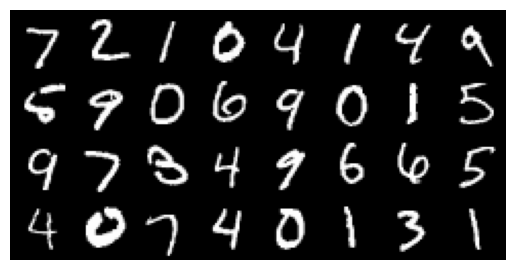

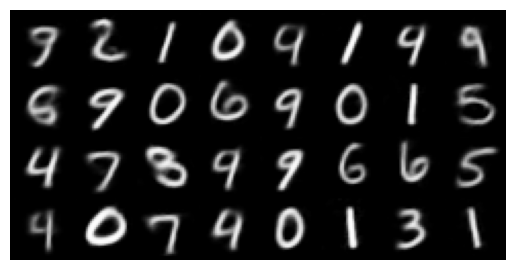

In [214]:
# VAE Tests
# TAs will change these paths as you will have provided the model files manually
"""To TAs, you should have been creating a folder with the student uid
   And the .ipynb + models in the root. Then that path is './VAE_model.pth' etc.
"""
vae = model_G = torch.jit.load('./CW_VAE/VAE_model.pth')
vae.eval()

# Check if VAE is convolutional
def recurse_cnn_check(parent, flag):
    if flag:
        return flag
    children = list(parent.children())
    if len(children) > 0:
        for child in children:
            flag = flag or recurse_cnn_check(child, flag)
    else:
        params = parent._parameters
        if 'weight' in params.keys():
            flag = params['weight'].ndim == 4
    return flag

has_cnn = recurse_cnn_check(vae, False)
print("Used CNN" if has_cnn else "Didn't Use CNN")

vae_in = make_grid(vae_denorm(vae_input), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure()
plt.axis('off')
show(vae_in)

vae_test = vae(vae_input.to(device))[0].detach()
vae_reco = make_grid(vae_denorm(vae_test), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure()
plt.axis('off')
show(vae_reco)

Number of Parameters is 2502272 which is ok


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


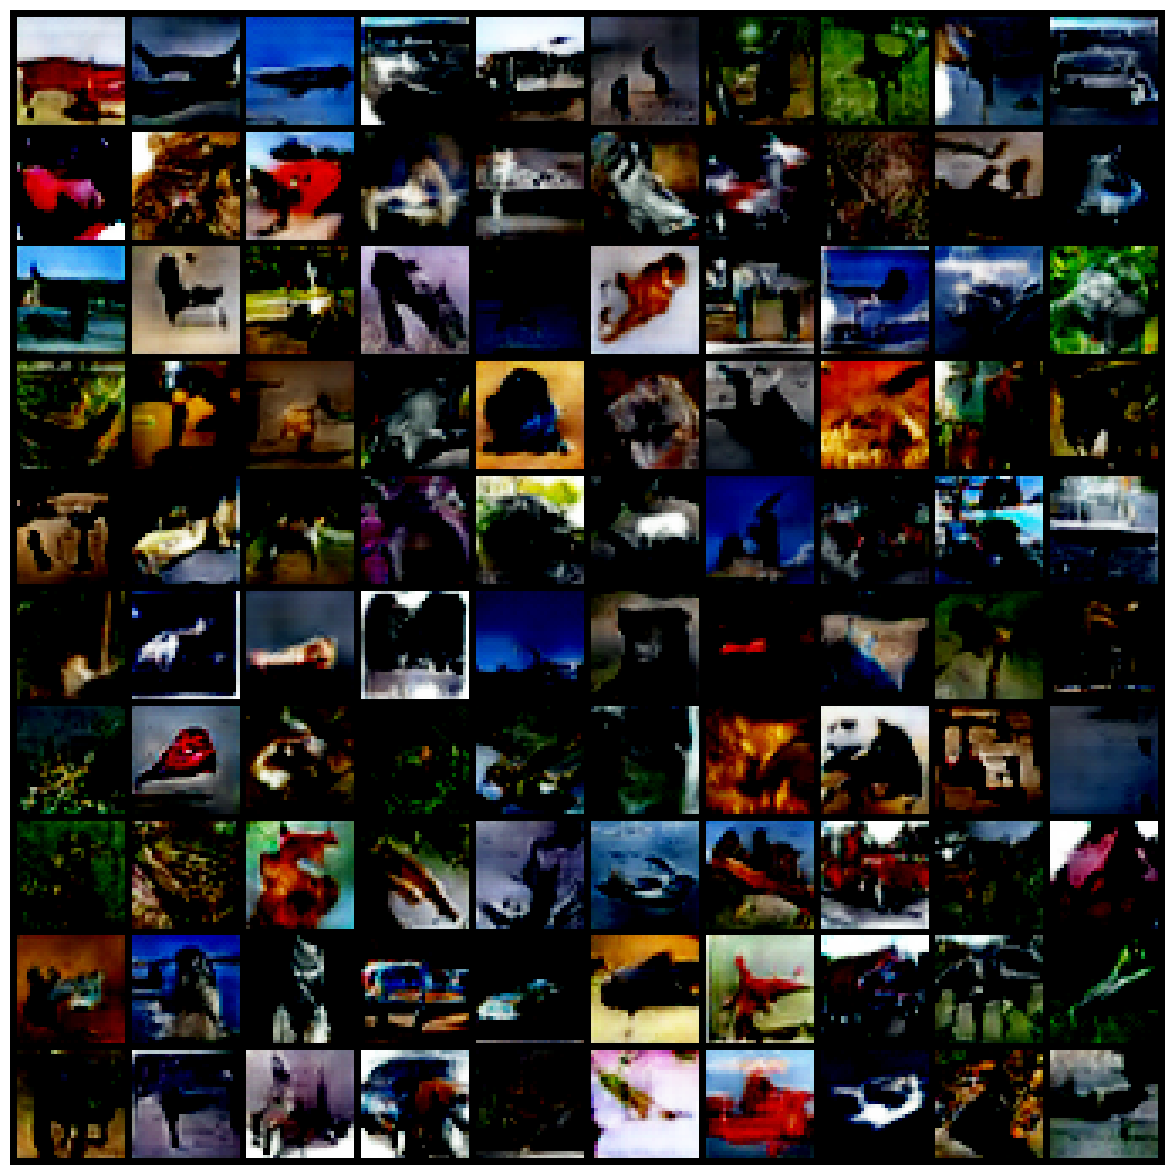

In [215]:
# GAN Tests
model_G = torch.jit.load('./CW_GAN/GAN_G_model.pth')
model_D = torch.jit.load('./CW_GAN/GAN_D_model.pth')
[model.eval() for model in (model_G, model_D)]

# Check that GAN doesn't have too many parameters
num_param = sum(p.numel() for p in [*model_G.parameters(),*model_D.parameters()])

print(f"Number of Parameters is {num_param} which is", "ok" if num_param<25E+6 else "not ok")

# visualize the generated images
generated = model_G(*gan_input).cpu()
generated = make_grid(gan_denorm(generated)[:100].detach(), nrow=10, padding=2, normalize=False,
                    value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
plt.axis('off')
show(generated)